In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [3]:

df = pd.read_csv('/app/GroupProject/creditcard.csv')
pd.set_option('display.max_columns', None)

([<matplotlib.patches.Wedge at 0xffff315eeba0>,
 [Text(1.0999838009225849, 0.005969732649226358, 'Fraud'),
  Text(-1.0999838004750038, -0.005969815120018522, 'UnFraud')],
 [Text(0.5999911641395917, 0.003256217808668922, '0.2%'),
  Text(-0.5999911638954565, -0.003256262792737375, '99.8%')])

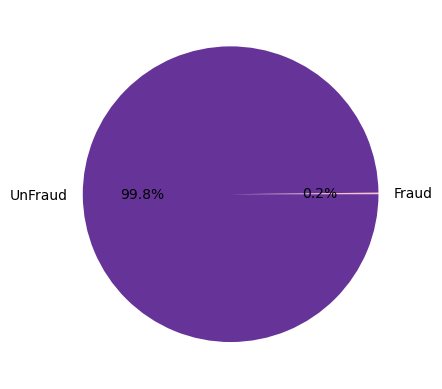

In [4]:
CheckBalanced = df['Class'].value_counts()
Fraud = len(df[df['Class']==1])
UnFraud = len(df[df['Class']==0])
fig, ax = plt.subplots()

sizes = [Fraud,UnFraud]
sizes
labels = 'Fraud','UnFraud'
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['pink','rebeccapurple'])


In [5]:
NACheck = df.apply(lambda x: x.isna().sum(), axis=1)
NACheck.describe()

count    284807.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
dtype: float64

# Missing data:
There is not any missing data
# Balanced data:
As we can see, the data we get is seriously imbalanced, so at first we need to use some methods for letting data balanced
- At First, what we want to use is only take limited unfraud credit card in order to make the data bakanced
- We want to let the Fraud data can be replaced after being taken out
- We want to use the Smote method in order to create Unfraud data betweem two fraud data

In order to double check whether it has some not available number

# Feature Selection
Choose Which Column is good for the Classification or not

In [6]:
correlation = df.corrwith(df['Class']).sort_values(ascending= False).to_frame()
correlation.columns = ['corr']
PositiveCorrelation = correlation[correlation['corr']>0.1]
NegativeCorrelation = correlation[correlation['corr']<-0.1]
correlation


,corr
Class,1.000000
V11,0.154876
V4,0.133447
V2,0.091289
V21,0.040413
V19,0.034783
V20,0.020090
V8,0.019875
V27,0.017580
V28,0.009536


In [7]:
FeatureTemp = NegativeCorrelation.index .append(PositiveCorrelation.index)
FilterSelectionColumn = df[FeatureTemp]
LastColumn = FilterSelectionColumn.pop('Class')
FilterSelectionColumn.insert(len(FeatureTemp)-1, 'Class',LastColumn) 
FilterSelectionColumn

,V1,V18,V7,V3,V16,V10,V12,V14,V17,V11,V4,Class
0,-1.359807,0.025791,0.239599,2.536347,-0.470401,0.090794,-0.617801,-0.311169,0.207971,-0.551600,1.378155,0
1,1.191857,-0.183361,-0.078803,0.166480,0.463917,-0.166974,1.065235,-0.143772,-0.114805,1.612727,0.448154,0
2,-1.358354,-0.121359,0.791461,1.773209,-2.890083,0.207643,0.066084,-0.165946,1.109969,0.624501,0.379780,0
3,-0.966272,1.965775,0.237609,1.792993,-1.059647,-0.054952,0.178228,-0.287924,-0.684093,-0.226487,-0.863291,0
4,-1.158233,-0.038195,0.592941,1.548718,-0.451449,0.753074,0.538196,-1.119670,-0.237033,-0.822843,0.403034,0
...,...,...,...,...,...,...,...,...,...,...,...,...
284802,-11.881118,0.510632,-4.918215,-9.834783,1.107641,4.356170,2.711941,4.626942,1.991691,-1.593105,-2.066656,0
284803,-0.732789,-1.221179,0.024330,2.035030,-0.711757,-0.975926,0.915802,-0.675143,-0.025693,-0.150189,-0.738589,0
284804,1.919565,0.395652,-0.296827,-3.249640,0.140716,-0.484782,0.063119,-0.510602,0.313502,0.411614,-0.557828,0
284805,-0.240440,1.113981,-0.686180,0.702510,-0.608577,-0.399126,-0.962886,0.449624,0.509928,-1.933849,0.689799,0


# Anova Test
Choose which option is good for the  Classification

In [8]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
features =df.drop('Class',axis=1)
FilterSelectionColumn
target = df['Class']
best_features = SelectKBest(score_func= f_classif,k = 'all')
fit = best_features.fit(features,target)
featureScores = pd.DataFrame(data = fit.scores_,index = list(features.columns),columns = ['ANOVA Score']) 
featureScores

,ANOVA Score
Time,43.252998
V1,2955.668946
V2,2393.401678
V3,11014.508305
V4,5163.832114
V5,2592.357929
V6,543.510578
V7,10349.605408
V8,112.548287
V9,2746.600273


# Decision
Choose the column which ANOVA and Correlation all plays key role for the classifiction

In [9]:
df = FilterSelectionColumn

In [10]:
Unfrauddf = df[df['Class']==0]
frauddf = df[df['Class']==1]



In [11]:
RandomUnfraud = Unfrauddf.sample(n = 492,replace=False)
CrossValidationDf = pd.concat([RandomUnfraud, frauddf])
CrossValidationDf

,V1,V18,V7,V3,V16,V10,V12,V14,V17,V11,V4,Class
20304,-0.578867,-0.105953,0.646349,1.186316,0.380220,-0.185710,-0.286086,-0.417295,0.023880,-0.258423,0.015943,0
26137,-1.116340,-0.283941,-0.635650,2.264930,0.966301,1.068506,-1.230672,-0.328243,0.322361,1.150558,-0.903777,0
155215,1.976181,0.263022,-0.574554,-0.163684,0.159227,-0.592463,-2.266669,1.621994,0.162865,0.187006,0.550747,0
215645,-0.128941,1.617069,0.042627,0.276412,-1.681516,-0.011391,-0.551916,0.095146,-0.339987,-1.598111,-1.278763,0
153581,1.868639,1.096753,-1.041661,0.274273,0.592554,-0.363116,-1.750036,1.550353,-0.100817,1.695184,0.625062,0
...,...,...,...,...,...,...,...,...,...,...,...,...
279863,-1.927883,-1.315147,-0.882850,-4.518331,-2.897825,-5.587794,-5.417424,-6.665177,-4.570529,2.115795,1.749293,1
280143,1.378559,-0.688505,-1.413170,-5.004247,-2.155297,-3.232153,-3.096915,-5.210141,-3.267116,2.858466,1.411850,1
280149,-0.676143,-0.507000,-2.234739,-2.213700,-1.603015,-3.463891,-2.775022,-4.057162,-5.035326,1.794969,0.468308,1
281144,-3.113832,-1.478138,-2.208002,-5.399730,-2.549498,-5.245984,-5.030465,-6.416628,-4.614717,1.933520,1.817092,1


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn import svm
CrossValidationDfX = CrossValidationDf.drop('Class',axis = "columns")
CrossValidationDfy = CrossValidationDf["Class"]
X_train,X_test,y_train,y_test = train_test_split(CrossValidationDfX,CrossValidationDfy,test_size = 0.2,random_state = 0)
X_train.shape, y_train.shape
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
scores = cross_val_score(clf,CrossValidationDfX, CrossValidationDfy, cv=10)
scores.mean()

0.9399917542774686

# Extreme Gradient Boosting
  I want to use the XGBoost for solving the imbalanced data, and Using high penalty to misclassifications of the minority class

In [13]:
XGBoostdfX = df.drop('Class',axis = "columns")
XGBoostdfy = df['Class']
X_train,X_test,y_train,y_test = train_test_split(XGBoostdfX,XGBoostdfy,test_size = 0.2,random_state = 0)
ratio = float(y_train.value_counts()[0]) / y_train.value_counts()[1]
ratio

581.7237851662404

In [14]:
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.metrics import accuracy_score

from sklearn.metrics import roc_auc_score, f1_score
import seaborn as sns

model = xgb.XGBClassifier(scale_pos_weight=ratio)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
print(confusion_matrix(y_test, y_pred))
confuse_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"AUC-ROC: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56861
           1       0.85      0.85      0.85       101

    accuracy                           1.00     56962
   macro avg       0.93      0.93      0.93     56962
weighted avg       1.00      1.00      1.00     56962

[[56846    15]
 [   15    86]]
AUC-ROC: 0.9805


Text(0.5, 1.0, 'Confusion Matrix Plotting')

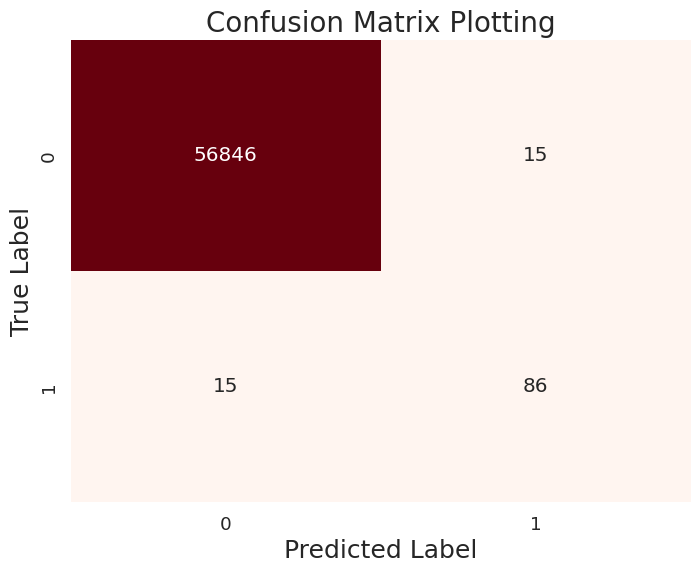

In [15]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(confuse_matrix , annot=True, fmt = 'g', cmap="Reds", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting", size = 20)

# Random Forest

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import seaborn as sns

X, y = make_classification(n_samples=1500, n_features=15, n_informative=5, n_redundant=1, n_classes=2, weights=[0.90, 0.10])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
print(f"Standard Random Forest Accuracy: acc_rf:.2f")
confuse_matrix_rf = confusion_matrix(y_test,  y_pred_rf)



Standard Random Forest Accuracy: acc_rf:.2f


Text(0.5, 1.0, 'Confusion Matrix Plotting')

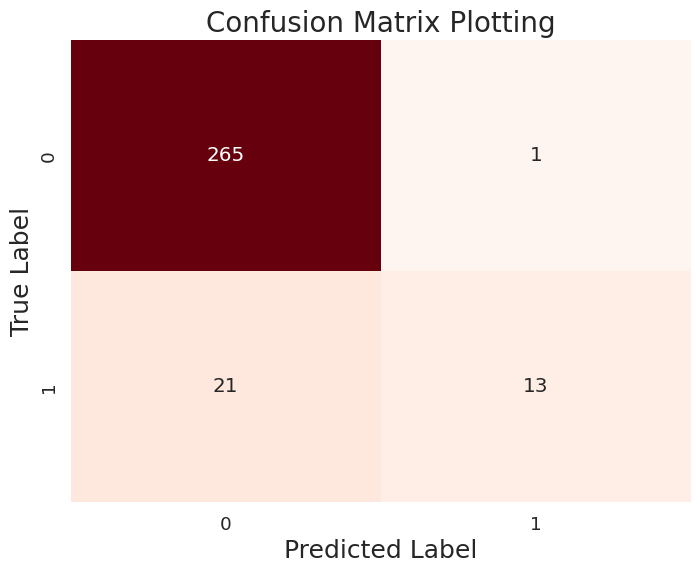

In [17]:
plt.figure(figsize=(8,6))
sns.set(font_scale=1.2)
sns.heatmap(confuse_matrix_rf , annot=True, fmt = 'g', cmap="Reds", cbar = False)
plt.xlabel("Predicted Label", size = 18)
plt.ylabel("True Label", size = 18)
plt.title("Confusion Matrix Plotting", size = 20)

Then we want to choose the conjunction of ANOVA Test and the Correlation

# OverSample UnderSample

In [18]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn import preprocessing


In [19]:
lab = preprocessing.LabelEncoder()
features = FilterSelectionColumn.values
target = LastColumn.values
target = lab.fit_transform(target)
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)
steps = [('under', under), ('over', over)]
pipeline = Pipeline(steps=steps)
features_resampled, target_resampled = pipeline.fit_resample(features , target)
print(Counter(target_resampled))
features_resampled


Counter({0: 4920, 1: 2460})


array([[  1.04006336,   0.04391304,  -0.0908988 , ...,  -0.40144273,
          0.1774316 ,   0.        ],
       [  1.49825397,  -0.8203997 ,  -0.07428114, ...,   0.48507969,
         -1.09770912,   0.        ],
       [  1.13167444,   0.28527767,   0.07923781, ...,  -0.20319512,
          2.6814137 ,   0.        ],
       ...,
       [ -1.87390893,  -2.30671224,  -2.75681679, ...,   2.21299335,
          2.06349356,   1.        ],
       [  2.07739316,   0.84062105,   0.77648246, ...,   0.07605071,
          0.4732206 ,   1.        ],
       [-11.78973902,  -7.77920663, -13.94695208, ...,   6.39537231,
          8.79634102,   1.        ]])

In [20]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

Epoch 1/80


/home/yuyang/.local/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.4241 - loss: 0.3117 - val_accuracy: 0.8625 - val_loss: 0.0441
Epoch 2/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9203 - loss: 0.0597 - val_accuracy: 0.8625 - val_loss: 0.0346
Epoch 3/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9167 - loss: 0.0461 - val_accuracy: 0.8625 - val_loss: 0.0324
Epoch 4/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9086 - loss: 0.0468 - val_accuracy: 0.8625 - val_loss: 0.0308
Epoch 5/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9130 - loss: 0.0412 - val_accuracy: 0.8625 - val_loss: 0.0298
Epoch 6/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9119 - loss: 0.0430 - val_accuracy: 0.8667 - val_loss: 0.0285
Epoch 7/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9179 - loss: 0.0362 - val_accuracy: 0.8667 - val_loss: 0.0284
Epoch 8/80
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9206 - loss: 0.0340 - val_accuracy: 0.8833 - val_loss: 0.0274
Epo

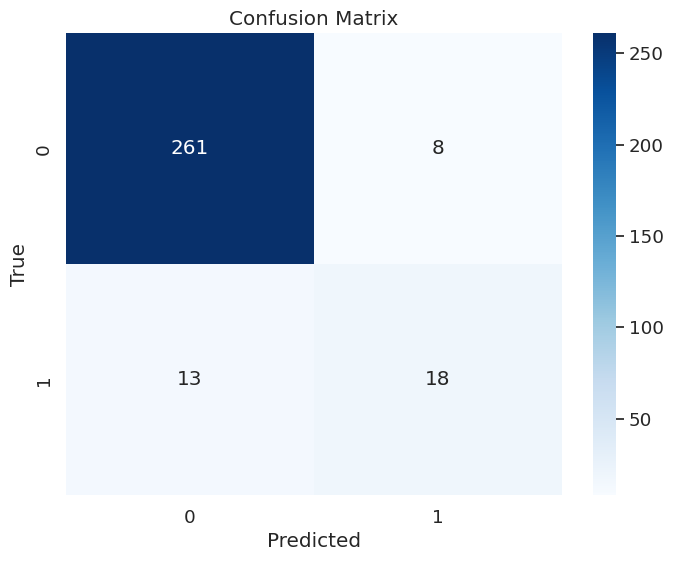

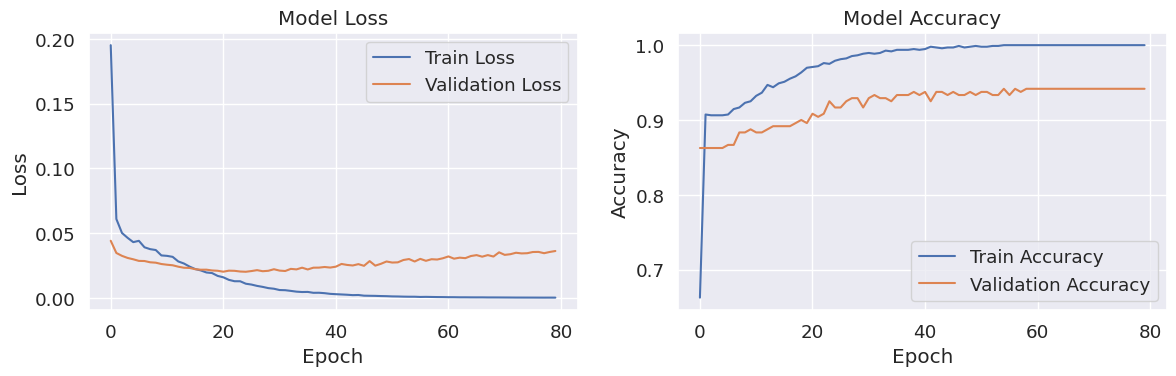

In [21]:
from tensorflow.keras import backend as K
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

n_samples = len(y_train)
n_positive = sum(y_train)
ratio = (n_samples - n_positive) / n_positive
class_weight = {0: 1, 1: ratio}

def focal_loss(gamma=2., alpha=.25):
    def focal_loss_fixed(y_true, y_pred):
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=focal_loss(),
              metrics=['accuracy'])

history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=80,
                    validation_split=0.2,
                    class_weight=class_weight,
                    verbose=1,
                    )

y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.3).astype(int)  
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC: {roc_auc:.4f}")
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()